In [8]:
import sys
sys.path.insert(0, "../src/")

import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from models import DummyNet
from losses import OnlineTripletLossMining
from torchvision import transforms
from torchvision.datasets import ImageFolder
%matplotlib inline

dtype = torch.float
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [9]:
filename = "../15.jpg"

In [10]:
@torch.no_grad()
def euclidean_distance(x1, x2):
    x = torch.cat((x1, x2), dim=0)
    distance = OnlineTripletLossMining()
    return distance._euclidean_distance(x)[0,1]

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint = torch.load("../checkpoints/checkpoint_500.pkl", map_location=device)
model = DummyNet()
model = torch.nn.DataParallel(model)
model = model.to(device)
model.load_state_dict(checkpoint["model"], strict=False)

<All keys matched successfully>

In [12]:
tr = transforms.Compose([transforms.ToTensor(), transforms.Resize((224, 224))])
dataset = ImageFolder("../dataset/", transform=tr)
num_folders = len(dataset.classes)
total_num_imgs = len(dataset.targets)

arr = torch.tensor(dataset.targets, device=device, dtype=dtype)
memo = {index: None for index in range(num_folders)}

In [13]:
pos, pos_lbl = filename, 3
pos = Image.open(pos).convert("RGB")
pos = tr(pos).unsqueeze(0).to(device)
pos_embedding = model(pos)

for m in memo.keys():
    xx_indice = random.choice(torch.where(arr==m)[0].cpu().numpy())
    xx, xx_lbl = dataset.imgs[xx_indice]
    xx = Image.open(xx).convert("RGB")
    xx = tr(xx).unsqueeze(0).to(device)
    xx_embedding = model(xx)
    memo[m] = dataset.classes[xx_lbl], xx_indice, euclidean_distance(pos_embedding, xx_embedding)

best = min(memo.values(), key=lambda item: item[-1])
best

('Advent', 3, tensor(219.4989, device='cuda:0'))

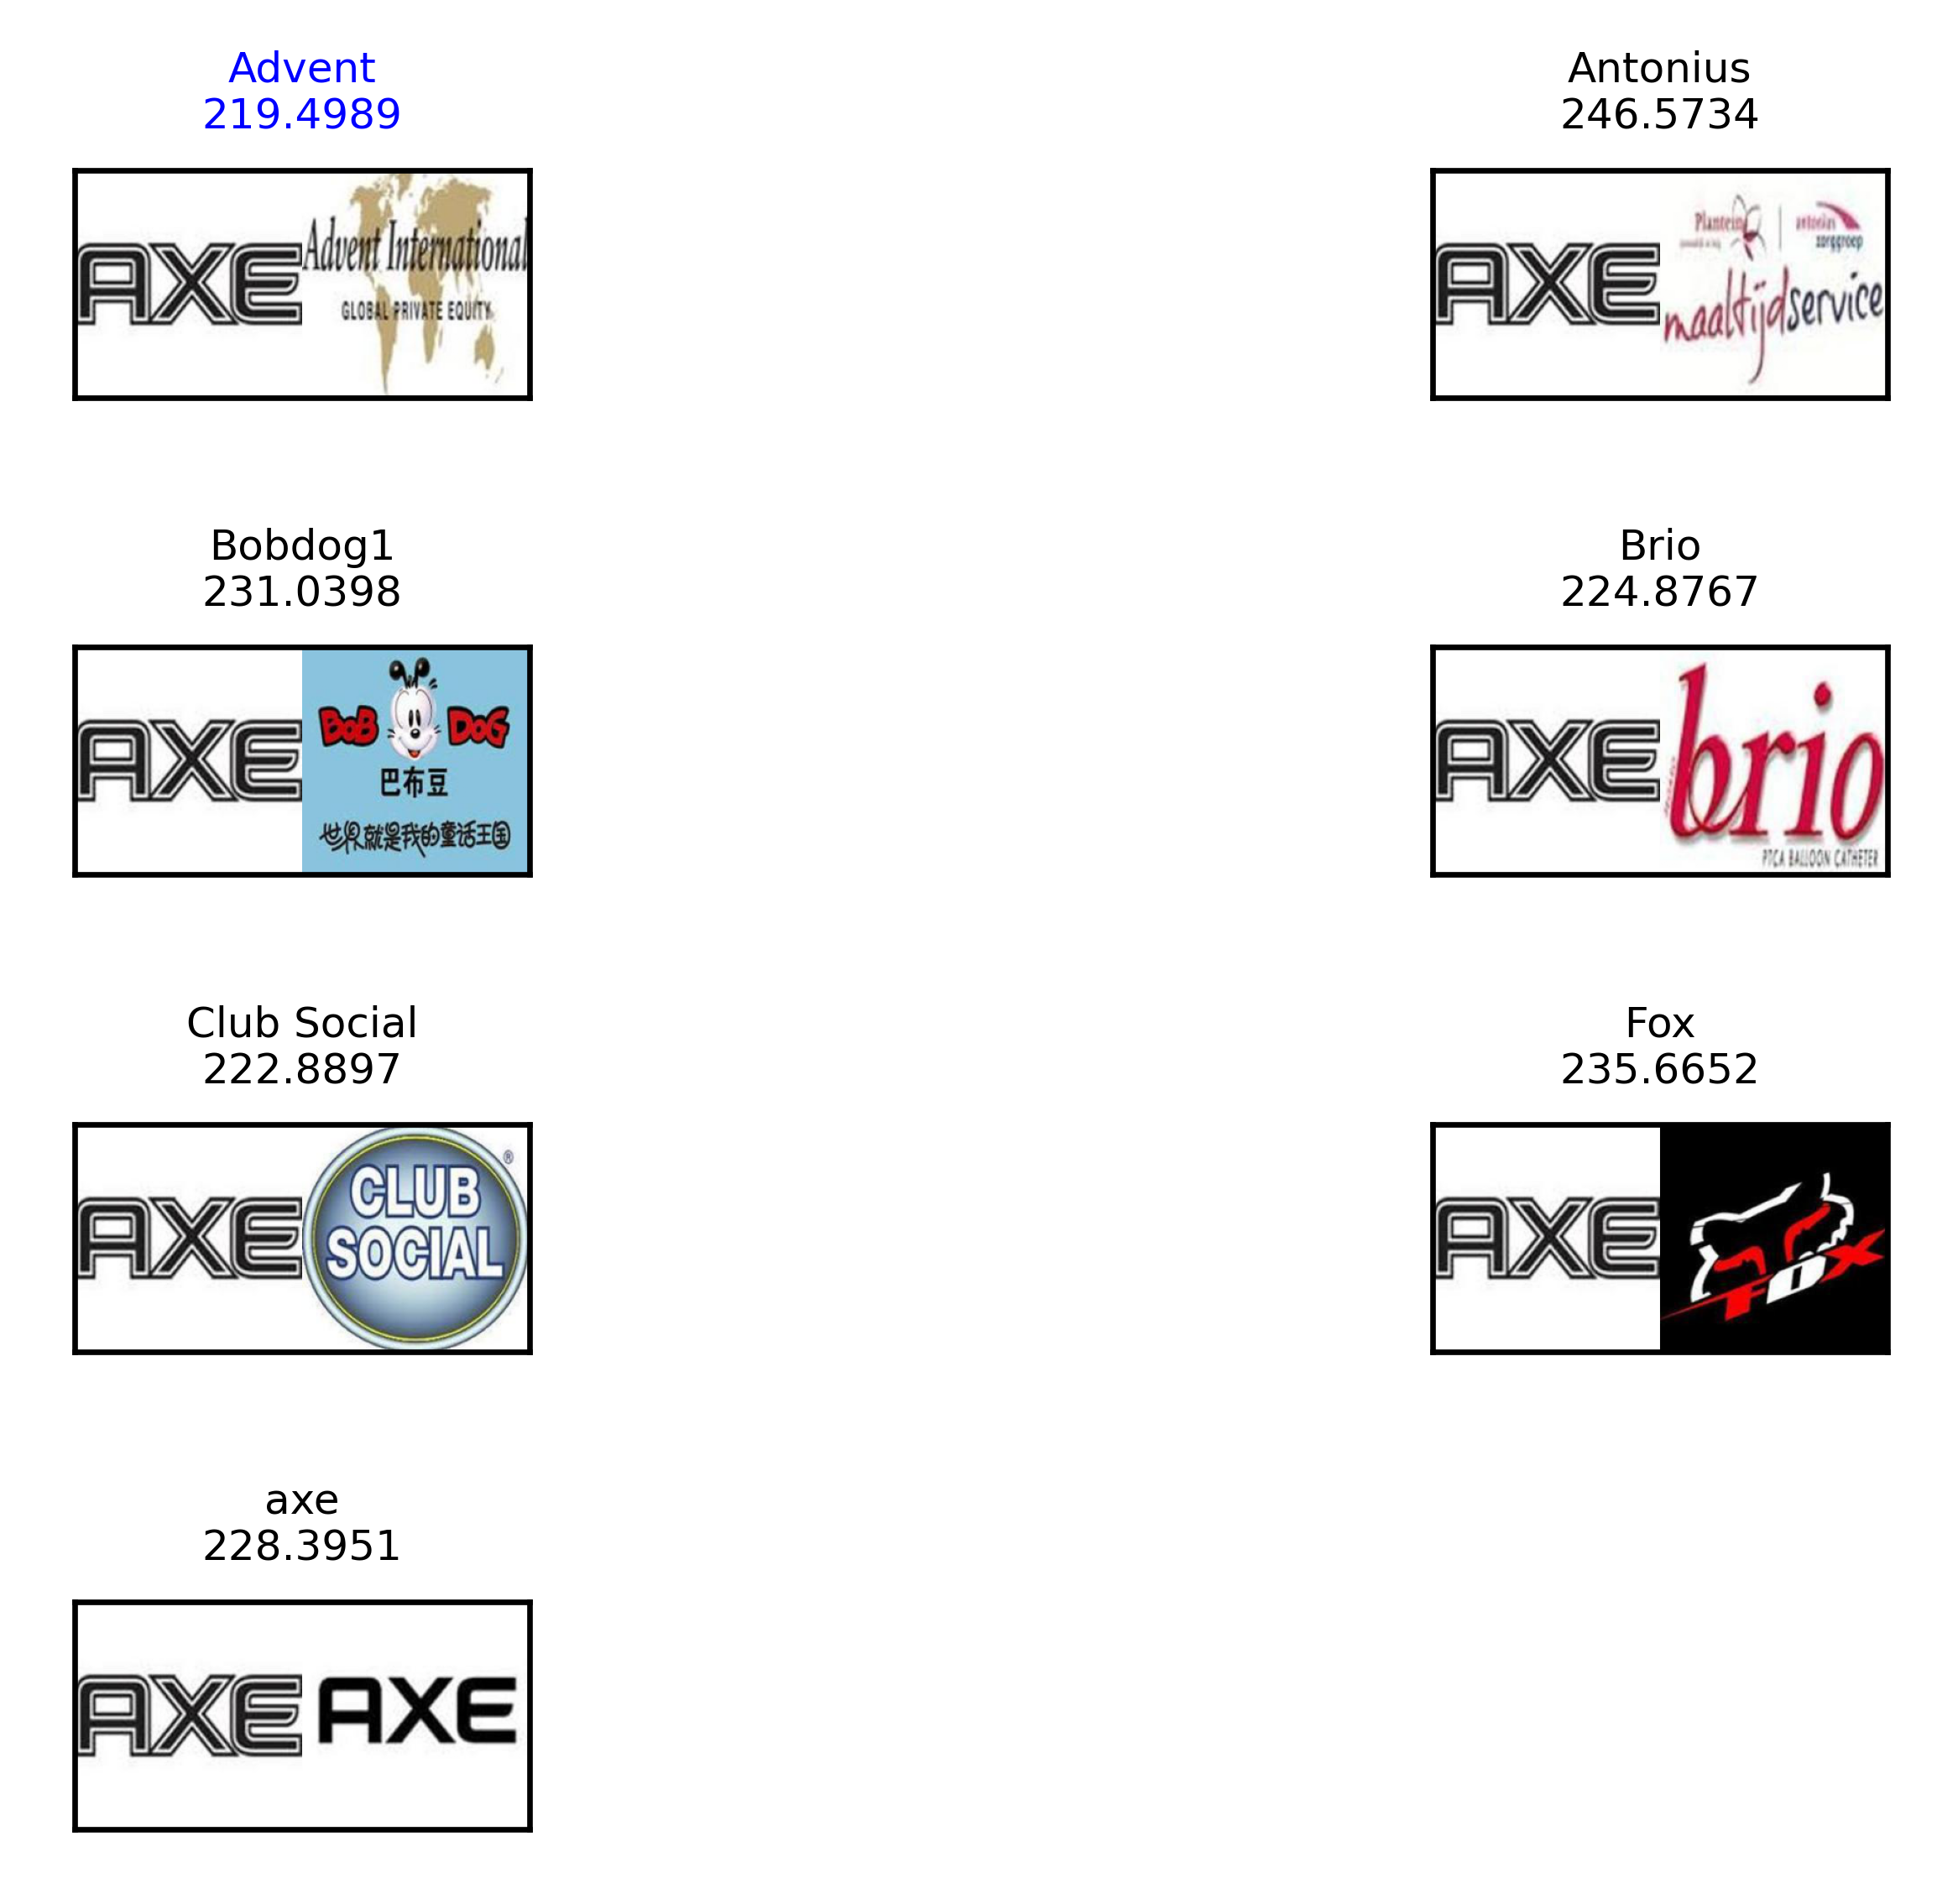

In [16]:
h, w = (num_folders+1)//2, 2
fig, axs = plt.subplots(h, w, dpi=600)

pos = Image.open(filename).convert("RGB")
pos = tr(pos).cpu().numpy().transpose(1, 2, 0)

anchor = Image.open(dataset.imgs[memo[5][1]][0]).convert("RGB")
anchor = tr(anchor).cpu().numpy().transpose(1, 2, 0)
for i, (ax, m) in enumerate(zip(axs.flat, memo.values())):
    neg = Image.open(dataset.imgs[m[1]][0]).convert("RGB")
    neg = tr(neg).cpu().numpy().transpose(1, 2, 0)

    ax.imshow(
        np.concatenate((pos, neg), axis=1)
    )

    xlabel = "{}\n{:.4f}".format(m[0], m[-1].item())
    if best[1] == m[1]:
        ax.set_title(xlabel, fontsize=6, color="blue")
    else:
        ax.set_title(xlabel, fontsize=6, color="black")
    ax.set_xticks([])
    ax.set_yticks([])

for ax in axs.flat:
    if not bool(ax.has_data()):
        fig.delaxes(ax)

fig.tight_layout(pad=1.5)
fig.savefig("out_.jpg")